In [1]:
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv,
    global_mean_pool,
)
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

In [2]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Preprocessing SMILES Data into Graphs

In [3]:
# Function to extract atom features
def atom_features(atom):
    return torch.tensor(
        [
            atom.GetAtomicNum(),            # Atomic number
            atom.GetDegree(),               # Number of connected neighbors
            atom.GetImplicitValence(),      # Implicit valence
            atom.GetFormalCharge(),         # Formal charge
            atom.GetIsAromatic(),           # Aromaticity
        ],
        dtype=torch.float,
    )


# Function to extract bond features
def bond_features(bond):
    bond_type = bond.GetBondTypeAsDouble()            # Bond type as a float
    is_aromatic = bond.GetIsAromatic()                # Aromatic bond
    is_conjugated = bond.GetIsConjugated()            # Conjugated bond
    is_in_ring = bond.IsInRing()                      # Whether the bond is part of a ring
    stereo = bond.GetStereo()                         # Bond stereochemistry
    
    # Convert stereo information to a one-hot encoded format
    stereo_one_hot = [0, 0, 0, 0]  # Stereo options: None, E, Z, Other
    if stereo == Chem.BondStereo.STEREONONE:
        stereo_one_hot[0] = 1
    elif stereo == Chem.BondStereo.STEREOE:
        stereo_one_hot[1] = 1
    elif stereo == Chem.BondStereo.STEREOZ:
        stereo_one_hot[2] = 1
    else:
        stereo_one_hot[3] = 1
    
    # Combine all features into a single tensor
    return torch.tensor(
        [bond_type, float(is_aromatic), float(is_conjugated), float(is_in_ring)] + stereo_one_hot, dtype=torch.float
    )


# Convert SMILES to PyTorch Geometric Data object
def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)

    atom_features_list = []
    edge_index = []
    edge_attr = []

    # Nodes (atoms)
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_features(atom))

    # Edges (bonds)
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Append bidirectional edges for undirected graphs
        edge_index.append([i, j])
        edge_index.append([j, i])
        
        # Append bond features for both directions
        edge_attr.append(bond_features(bond))
        edge_attr.append(bond_features(bond))

    # Convert atom features to a tensor
    x = torch.stack(atom_features_list)

    # Convert edge indices and features to tensors, handle empty edge case
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.stack(edge_attr)
    else:
        # Handle molecules with no bonds
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0,), dtype=torch.float)

    # Label (target)
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)



# Function to load data from CSV and apply SMILES augmentation for training
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path)
    smiles_list = df["Smiles"].values
    labels = df["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0).values

    data_list = []

    # Initialize the SmilesEnumerator for data augmentation
    for smiles, label in zip(smiles_list, labels):
        # For test data, no augmentation, just use canonical SMILES
        graph_data = smiles_to_graph(smiles, label)
        data_list.append(graph_data)

    return data_list

In [7]:
# Load training and testing data
training_data = load_data_from_csv("data_smiles/Training_Group.csv")
testing_data = load_data_from_csv("data_smiles/Testing_Group.csv")

# Create data loaders
train_loader = DataLoader(training_data, batch_size=1, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=1, shuffle=False)

In [6]:
# for i, data in enumerate(test_loader):
#     print(data)

#     if i == 2:
#         break

DataBatch(x=[40, 5], edge_index=[2, 88], edge_attr=[88, 8], y=[1], batch=[40], ptr=[2])
DataBatch(x=[15, 5], edge_index=[2, 30], edge_attr=[30, 8], y=[1], batch=[15], ptr=[2])
DataBatch(x=[27, 5], edge_index=[2, 58], edge_attr=[58, 8], y=[1], batch=[27], ptr=[2])


In [15]:
# Training function with AUC and accuracy tracking
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    for data in data_loader:
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
        y_pred.extend(out[:, 1].detach().cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

In [16]:
# Evaluation function with AUC and accuracy tracking
def test(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Move data to GPU
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
            y_pred.extend(out[:, 1].cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

# GCN approach

## 2. Define GCN Model

In [17]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply graph convolution layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global pooling (average pooling) to get graph-level representations
        x = global_mean_pool(x, batch)  # Pooling over nodes in each graph

        # Final classification layer
        return F.log_softmax(self.fc(x), dim=1)

## 3. Training Loop with Early Stopping and Metric Tracking

In [18]:
# Initialize the model, optimizer, and loss function
model = GCN(num_node_features=5, num_classes=2).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, weight_decay=1e-4
)  # Increase weight decay value
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0
early_stop_counter = 0
max_epochs = 1000  # Max epochs
patience = 100  # Early stopping patience

# Metrics storage for plotting
train_acc_history, train_loss_history, train_auc_history = [], [], []
test_acc_history, test_loss_history, test_auc_history = [], [], []

for epoch in range(max_epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion)

    # Store metrics for plotting
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    train_auc_history.append(train_auc)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    test_auc_history.append(test_auc)

    print(f"Epoch {epoch+1}:")
    print(
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}"
    )
    print(
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}"
    )

    # Early stopping
    if test_auc > best_auc:
        best_auc = test_auc
        early_stop_counter = 0  # Reset counter if improvement
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1:
Train Loss: 0.6945, Train Acc: 0.5383, Train AUC: 0.5201
Test Loss: 0.6144, Test Acc: 0.7727, Test AUC: 0.7403
Epoch 2:
Train Loss: 0.6870, Train Acc: 0.5560, Train AUC: 0.5475
Test Loss: 0.7031, Test Acc: 0.4685, Test AUC: 0.7432
Epoch 3:
Train Loss: 0.6792, Train Acc: 0.5745, Train AUC: 0.5835
Test Loss: 0.6404, Test Acc: 0.6818, Test AUC: 0.7423
Epoch 4:
Train Loss: 0.6728, Train Acc: 0.5866, Train AUC: 0.6067
Test Loss: 0.6887, Test Acc: 0.6084, Test AUC: 0.7494
Epoch 5:
Train Loss: 0.6676, Train Acc: 0.5834, Train AUC: 0.6191
Test Loss: 0.6955, Test Acc: 0.5909, Test AUC: 0.7470
Epoch 6:
Train Loss: 0.6633, Train Acc: 0.6084, Train AUC: 0.6307
Test Loss: 0.5557, Test Acc: 0.7657, Test AUC: 0.7278
Epoch 7:
Train Loss: 0.6627, Train Acc: 0.5931, Train AUC: 0.6229
Test Loss: 0.6120, Test Acc: 0.7552, Test AUC: 0.7386
Epoch 8:
Train Loss: 0.6600, Train Acc: 0.6003, Train AUC: 0.6335
Test Loss: 0.6251, Test Acc: 0.7238, Test AUC: 0.7413
Epoch 9:
Train Loss: 0.6558, Train Acc: 

## 4. Evaluation function

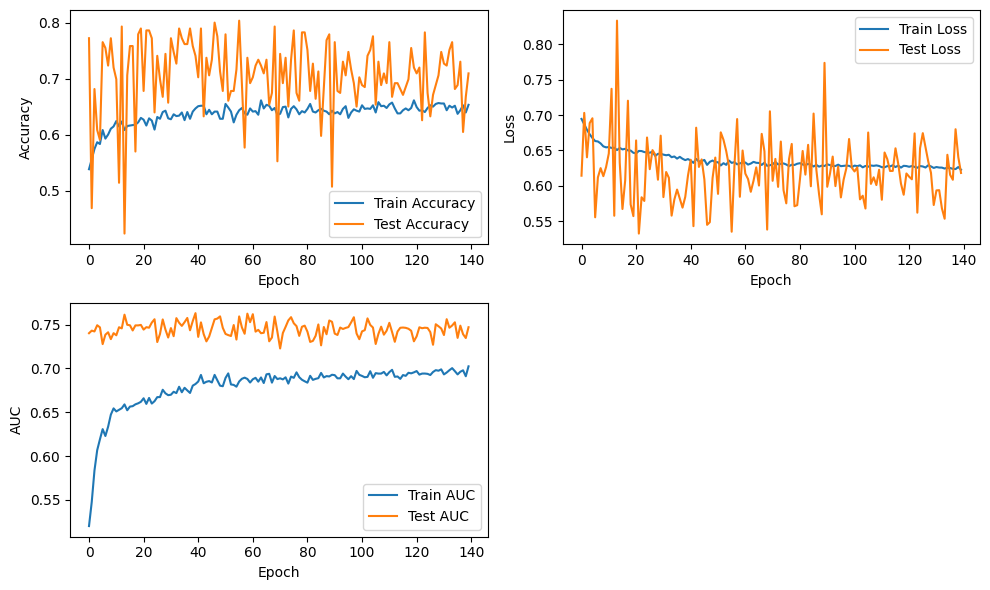

In [19]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()